# Load Senitnel-2 data from the CDSE STAC catalog

This notebook shows an example how to load Sentinel-2 data from the [CDSE STAC API](https://browser.stac.dataspace.copernicus.eu/?.language=en).

### Setup
In order to run this notebook you may install [`xcube_stac`](https://github.com/xcube-dev/xcube-stac). You may install [`xcube_stac`](https://github.com/xcube-dev/xcube-stac) directly from the git repository by cloning the repository, directing into `xcube-stac`, and following the steps below:

```bash
conda env create -f environment.yml
conda activate xcube-stac
pip install .
```

Note that [`xcube_stac`](https://github.com/xcube-dev/xcube-stac) is a plugin of [`xcube`](https://xcube.readthedocs.io/en/latest/), where `xcube` is included in the `environment.yml`.  

The data can be accessed via S3, where key and secret can be obtained following the [CDSE access documentation to EO data via S3](https://documentation.dataspace.copernicus.eu/APIs/S3.html#generate-secrets). The store object will receive the key and secret upon initialization, as demonstrated below.

Now, we first import everything we need:

In [1]:
%%time
import itertools

import matplotlib.pyplot as plt

from xcube.core.store import new_data_store, get_data_store_params_schema
from xcube_stac._utils import reproject_bbox

CPU times: user 4.59 s, sys: 374 ms, total: 4.96 s
Wall time: 3.12 s


Next store the credentials in a dictionary. 

In [2]:
credentials = {
    "key": "xxx",
    "secret": "xxx",
}

First, we get the store parameters needed to initialize a STAC [data store](https://xcube.readthedocs.io/en/latest/dataaccess.html#data-store-framework). Note that key and secret of the S3 access are required.

In [3]:
%%time
store_params = get_data_store_params_schema("stac-cdse")
store_params

CPU times: user 53 ms, sys: 14 ms, total: 67 ms
Wall time: 66.4 ms


Note that the user does not need to provide the URL for the [CDSE STAC API](https://documentation.dataspace.copernicus.eu/APIs/STAC.html). Only the key and secret for S3 access are required when initializing a `stac-cdse` [data store](https://xcube.readthedocs.io/en/latest/dataaccess.html#data-store-framework). First, we will initialize a store supporting the stacking mode. Then, for completeness, we will initialize a store in single-tile mode.

In [4]:
%%time
store = new_data_store("stac-cdse", stack_mode=True, **credentials)

CPU times: user 21.1 ms, sys: 1.22 ms, total: 22.3 ms
Wall time: 178 ms


The data IDs point to a STAC collections. So far only `'sentinel-2-l2a'` is supported.

In [5]:
%%time
data_ids = store.list_data_ids()
data_ids

CPU times: user 13.7 ms, sys: 382 μs, total: 14.1 ms
Wall time: 199 ms


['sentinel-1-grd',
 'sentinel-2-global-mosaics',
 'sentinel-2-l1c',
 'sentinel-2-l2a']

Below, the parameters for the `open_data` method can be viewed.

In [6]:
%%time
open_params = store.get_open_data_params_schema()
open_params

CPU times: user 327 μs, sys: 0 ns, total: 327 μs
Wall time: 330 μs


So far, only data from the collection `sentinel-2-l2a` can be accessed. We therefore assign `data_id` to `"sentinel-2-l2a"`. We set the bounding box to cover the greater Hamburg area and the time range to second half of July 2020.

In [7]:
%%time
bbox = [9.1, 53.1, 10.7, 54]
crs_target = "EPSG:32632"
bbox_utm = reproject_bbox(bbox, "EPSG:4326", crs_target)
time_range = ["2020-07-15", "2020-08-01"]

CPU times: user 3.02 ms, sys: 2 μs, total: 3.02 ms
Wall time: 2.61 ms


In [8]:
%%time
ds = store.open_data(
    data_id="sentinel-2-l2a",
    bbox=bbox_utm,
    time_range=time_range,
    spatial_res=20,
    crs=crs_target,
    asset_names=["B02", "B03", "B04"],
    apply_scaling=True,
    angles_sentinel2=True,
)
ds

CPU times: user 21 s, sys: 1.45 s, total: 22.5 s
Wall time: 1min 13s


<xarray.Dataset> Size: 4GB
Dimensions:        (time: 11, y: 5073, x: 5364, angle: 2, angle_x: 22,
                    angle_y: 21, band: 3)
Coordinates:
  * x              (x) float64 43kB 5.066e+05 5.066e+05 ... 6.138e+05 6.138e+05
  * y              (y) float64 41kB 5.985e+06 5.985e+06 ... 5.883e+06 5.883e+06
  * time           (time) datetime64[ns] 88B 2020-07-15T10:15:59.024000 ... 2...
    spatial_ref    int64 8B 0
  * angle          (angle) <U7 56B 'Zenith' 'Azimuth'
  * angle_x        (angle_x) float64 176B 5.066e+05 5.116e+05 ... 6.116e+05
  * angle_y        (angle_y) float64 168B 5.983e+06 5.978e+06 ... 5.883e+06
  * band           (band) <U5 60B 'B02' 'B03' 'B04'
Data variables:
    B02            (time, y, x) float32 1GB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    B03            (time, y, x) float32 1GB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    B04            (time, y, x) float32 1GB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    solar_angle    (time, angle, angle_y, angle_x) float64 81kB dask.array<chunksize=(1, 2, 21, 22), meta=np.ndarray>
    viewing_angle  (time, band, angle, angle_y, angle_x) float64 244kB dask.array<chunksize=(1, 3, 2, 21, 22), meta=np.ndarray>
Attributes:
    stac_catalog_url:  https://stac.dataspace.copernicus.eu/v1
    stac_item_ids:     {'2020-07-15T10:15:59.024000': ['S2B_MSIL2A_20200715T1...

Note that the search function in the CDSE STAC API is very slow. Further investigation and comparison with other STAC APIs is needed. 

We can plot a tile of the B04 (red) band for a given timestamp as an example. Hereby a mosaicking of multiple tiles have been applied.

/home/konstantin/micromamba/envs/xcube-stac/lib/python3.12/site-packages/dask/array/chunk.py:139: RuntimeWarning: Mean of empty slice
  return reduction(x.reshape(newshape), axis=tuple(range(1, x.ndim * 2, 2)), **kwargs)


CPU times: user 1min 30s, sys: 4.11 s, total: 1min 35s
Wall time: 2min 8s


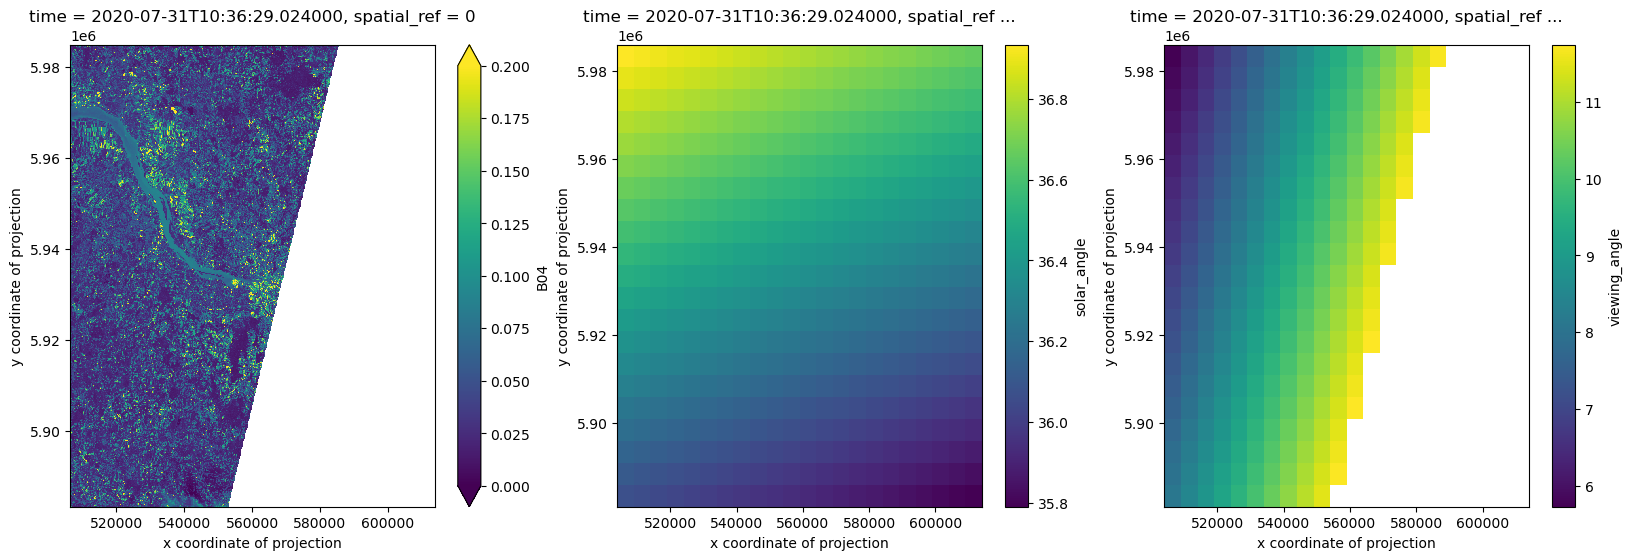

In [9]:
%%time
fig, ax = plt.subplots(1, 3, figsize=(20, 6))
ds.B04.isel(time=-1)[::10, ::10].plot(ax=ax[0], vmin=0, vmax=0.2)
ds.solar_angle.isel(angle=0, time=-1).plot(ax=ax[1])
ds.viewing_angle.isel(band=0-1, angle=0, time=-1).plot(ax=ax[2])

----
## Data store in the single-tile
For completeness, we initiate the data store in the single-tile mode and open data of one tile. 

In [10]:
%%time
store = new_data_store("stac-cdse", stack_mode=False, **credentials)

CPU times: user 12.2 ms, sys: 3.97 ms, total: 16.2 ms
Wall time: 229 ms


The data IDs point to a [STAC item's JSON](https://github.com/radiantearth/stac-spec/blob/master/item-spec/item-spec.md) and are specified by the segment of the URL that follows the catalog's URL. The data IDs can be streamed using the following code where we show the first 10 data IDs as an example.

In [11]:
%%time
data_ids = store.get_data_ids()
list(itertools.islice(data_ids, 10))

CPU times: user 23.4 ms, sys: 2.28 ms, total: 25.7 ms
Wall time: 481 ms


['collections/sentinel-2-l1c/items/S2B_MSIL1C_20250123T103239_N0511_R108_T34WES_20250123T122758',
 'collections/sentinel-2-l1c/items/S2B_MSIL1C_20250123T103239_N0511_R108_T34WDT_20250123T122758',
 'collections/sentinel-2-l1c/items/S2B_MSIL1C_20250123T103239_N0511_R108_T34VDQ_20250123T122758',
 'collections/sentinel-2-l1c/items/S2B_MSIL1C_20250123T103239_N0511_R108_T34VCQ_20250123T122758',
 'collections/sentinel-2-l1c/items/S2B_MSIL1C_20250123T103239_N0511_R108_T33WVN_20250123T122758',
 'collections/sentinel-2-l1c/items/S2B_MSIL1C_20250123T103239_N0511_R108_T33WVM_20250123T122758',
 'collections/sentinel-2-l1c/items/S2B_MSIL1C_20250123T103239_N0511_R108_T33VXK_20250123T122758',
 'collections/sentinel-2-l1c/items/S2B_MSIL1C_20250123T103239_N0511_R108_T33VVL_20250123T122758',
 'collections/sentinel-2-l1c/items/S2B_MSIL1C_20250123T103239_N0511_R108_T32SKJ_20250123T125425',
 'collections/sentinel-2-l1c/items/S2B_MSIL1C_20250123T103239_N0511_R108_T31TDE_20250123T125425']

In the next step, we can search for items using search parameters. The following code shows which search parameters are available.

In [12]:
%%time
search_params = store.get_search_params_schema()
search_params

CPU times: user 56 μs, sys: 3 μs, total: 59 μs
Wall time: 63.7 μs


 Next, we will search for tiles of Sentinel-2 data.

In [13]:
%%time
descriptors = list(
    store.search_data(
        collections=["sentinel-2-l2a"],
        bbox=[9, 47, 10, 48],
        time_range=["2020-07-01", "2020-07-05"],
    )
)
[d.to_dict() for d in descriptors]

CPU times: user 361 ms, sys: 24.1 ms, total: 385 ms
Wall time: 4.21 s


[{'data_id': 'collections/sentinel-2-l2a/items/S2B_MSIL2A_20200705T101559_N0500_R065_T32UNU_20230530T175912',
  'data_type': 'dataset',
  'bbox': [8.999728, 47.755819, 10.493269, 48.753013],
  'time_range': ('2020-07-05T10:15:59.024Z', '2020-07-05T10:15:59.024Z')},
 {'data_id': 'collections/sentinel-2-l2a/items/S2B_MSIL2A_20200705T101559_N0500_R065_T32UMU_20230530T175912',
  'data_type': 'dataset',
  'bbox': [8.087776, 47.759622, 9.132783, 48.752937],
  'time_range': ('2020-07-05T10:15:59.024Z', '2020-07-05T10:15:59.024Z')},
 {'data_id': 'collections/sentinel-2-l2a/items/S2B_MSIL2A_20200705T101559_N0500_R065_T32TNT_20230530T175912',
  'data_type': 'dataset',
  'bbox': [8.999733, 46.85664, 10.467277, 47.853702],
  'time_range': ('2020-07-05T10:15:59.024Z', '2020-07-05T10:15:59.024Z')},
 {'data_id': 'collections/sentinel-2-l2a/items/S2B_MSIL2A_20200705T101559_N0500_R065_T32TMT_20230530T175912',
  'data_type': 'dataset',
  'bbox': [7.760786, 46.858555, 9.13047, 47.853628],
  'time_range':

In the next step, we can open the data for each data ID. The following code shows which parameters are available for opening the data.

In [14]:
%%time
open_params = store.get_open_data_params_schema()
open_params

CPU times: user 174 μs, sys: 9 μs, total: 183 μs
Wall time: 188 μs


We select the band B04 (red), B03 (green), and B02 (blue) and lazily load the corresponding data.

In [15]:
%%time
ds = store.open_data(
    descriptors[3].data_id,
    asset_names=["B04", "B03", "B02"],
    apply_scaling=True,
    angles_sentinel2=True
)
ds

CPU times: user 209 ms, sys: 39 ms, total: 248 ms
Wall time: 6.12 s


<xarray.Dataset> Size: 1GB
Dimensions:        (x: 10980, y: 10980, angle: 2, angle_x: 23, angle_y: 23,
                    band: 3)
Coordinates:
  * x              (x) float64 88kB 4e+05 4e+05 4e+05 ... 5.097e+05 5.098e+05
  * y              (y) float64 88kB 5.3e+06 5.3e+06 ... 5.19e+06 5.19e+06
    spatial_ref    int64 8B 0
  * angle          (angle) <U7 56B 'Zenith' 'Azimuth'
  * angle_x        (angle_x) float64 184B 4.025e+05 4.075e+05 ... 5.125e+05
  * angle_y        (angle_y) float64 184B 5.298e+06 5.293e+06 ... 5.188e+06
  * band           (band) <U5 60B 'B02' 'B03' 'B04'
Data variables:
    B04            (y, x) float32 482MB dask.array<chunksize=(1024, 1024), meta=np.ndarray>
    B03            (y, x) float32 482MB dask.array<chunksize=(1024, 1024), meta=np.ndarray>
    B02            (y, x) float32 482MB dask.array<chunksize=(1024, 1024), meta=np.ndarray>
    solar_angle    (angle, angle_y, angle_x) float64 8kB 28.4 28.38 ... 148.2
    viewing_angle  (band, angle, angle_y, angle_x) float64 25kB nan ... 123.6
Attributes:
    stac_catalog_url:  https://stac.dataspace.copernicus.eu/v1
    stac_item_id:      S2B_MSIL2A_20200705T101559_N0500_R065_T32TMT_20230530T...

We plot the loaded data as an example below.

CPU times: user 38.4 s, sys: 973 ms, total: 39.4 s
Wall time: 28.3 s


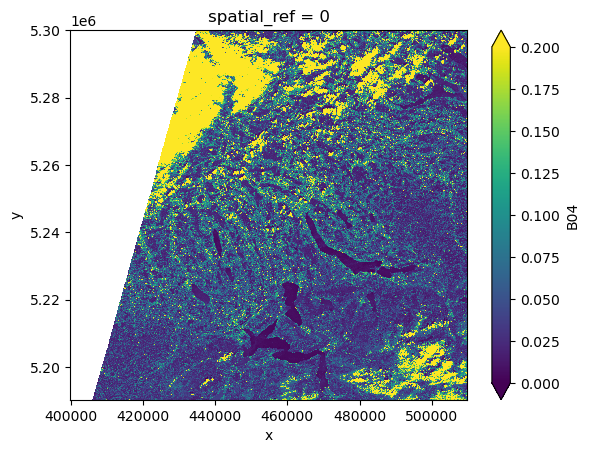

In [16]:
%%time
ds.B04[::10, ::10].plot(vmin=0.0, vmax=0.2)

We can also open a `.jp2` as a [xcube's multi-resolution  dataset](https://xcube.readthedocs.io/en/latest/mldatasets.html#xcube-multi-resolution-datasets), where we can select the level of resolution, shown below.  

In [17]:
%%time
mlds = store.open_data(
    descriptors[3].data_id,
    data_type="mldataset",
    asset_names=["B04", "B03", "B02"],
    apply_scaling=True
)
mlds.num_levels

CPU times: user 34.5 ms, sys: 14 ms, total: 48.5 ms
Wall time: 867 ms


5

In [18]:
%%time
ds = mlds.get_dataset(2)
ds

CPU times: user 43.4 ms, sys: 16 ms, total: 59.4 ms
Wall time: 449 ms


<xarray.Dataset> Size: 90MB
Dimensions:      (x: 2745, y: 2745)
Coordinates:
  * x            (x) float64 22kB 4e+05 4e+05 4.001e+05 ... 5.097e+05 5.097e+05
  * y            (y) float64 22kB 5.3e+06 5.3e+06 5.3e+06 ... 5.19e+06 5.19e+06
    spatial_ref  int64 8B 0
Data variables:
    B04          (y, x) float32 30MB dask.array<chunksize=(1024, 1024), meta=np.ndarray>
    B03          (y, x) float32 30MB dask.array<chunksize=(1024, 1024), meta=np.ndarray>
    B02          (y, x) float32 30MB dask.array<chunksize=(1024, 1024), meta=np.ndarray>
Attributes:
    stac_catalog_url:  https://stac.dataspace.copernicus.eu/v1
    stac_item_id:      S2B_MSIL2A_20200705T101559_N0500_R065_T32TMT_20230530T...

CPU times: user 5.37 s, sys: 1.6 s, total: 6.98 s
Wall time: 38.9 s


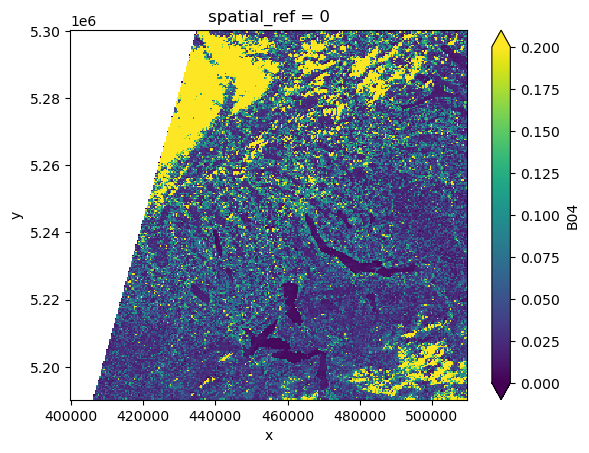

In [19]:
%%time
ds.B04[::10, ::10].plot(vmin=0.0, vmax=0.2)